## DATA ANALYSIS
### --to be put in thesis

## Imports etc.

In [2]:
import pandas as pd
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

Set defaults for plotting better visuals

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amsfonts}'

sns.set(font='Franklin Gothic Book',
        rc={
            'text.usetex': True,
            'font.family': 'serif',
            'text.latex.preamble': [r'\usepackage{amsmath}', r'\usepackage{amsfonts}'],
            'axes.axisbelow': False,
            'axes.edgecolor': 'lightgrey',
            'axes.facecolor': 'None',
            'axes.grid': False,
            'axes.labelcolor': 'black',
            'axes.spines.right': False,
            'axes.spines.top': False,
            'figure.facecolor': 'white',
            'lines.solid_capstyle': 'round',
            'patch.edgecolor': 'w',
            'patch.force_edgecolor': True,
            'text.color': 'black',
            'xtick.bottom': False,
            'xtick.color': 'black',
            'xtick.direction': 'out',
            'xtick.top': False,
            'ytick.color': 'black',
            'ytick.direction': 'out',
            'ytick.left': False,
            'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":18,
                                "axes.labelsize":14})


Create colour palette

In [4]:
M_darkpurple = '#783CBB'
M_lightpurple = '#A385DB'
# M_green = '#479C8A'
M_green = '#0a888a'
M_yellow = '#FFDD99'
M_lightpink = '#EFA9CD'
M_darkpink = '#E953AD'

colour_list = [M_lightpink, M_green, M_darkpurple, M_darkpink, M_lightpurple, M_yellow]
cd = {'lightpink': M_lightpink, 'lightpurple': M_lightpurple, 'green': M_green, 'purple': M_darkpurple, 'pink': M_darkpink, 'yellow': M_yellow}
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour_list)


## Load data

Read in patches
-- final data that is used (after preprocessing and deleting)

In [5]:
main_dir = '/home/21576262@su/masters/data/patches/'
labels_dir = '/home/21576262@su/masters/data/labels/'
case_files = os.listdir(main_dir)
img_folders = [main_dir + case for case in case_files]
label_files = [labels_dir + case + '.pt' for case in case_files]

In [6]:
# Load images and corresponding labels
DF = pd.DataFrame(columns=['case_id', 'Final total benign', 'Final total malignant'])
for i, (img_folder, label_file) in enumerate(zip(img_folders, label_files)):
    labels=[]
    df = {}
    labels_pt = torch.load(label_file) # Load .pt file
    case_id = img_folder.split('/')[-1]
    # Run through all patches from the case folder
    for i, img in enumerate(os.listdir(img_folder)):
        if os.path.isfile(os.path.join(img_folder, img)) and os.path.isfile(label_file):
            if img.startswith('._'):
                img = img.replace('._', '')
            idx = int(img.replace('.png', '').split("_")[1])
            labels.append(labels_pt[idx].item()) # get label as int
    num_zeros = labels.count(0)
    num_ones = labels.count(1)
    if num_zeros + num_ones != len(labels):
        raise ValueError("Sum of class 0 and 1 does not equal total labels found")
    temp_df = pd.DataFrame([{
        'case_id': case_id,
        'Final total benign': num_zeros,
        'Final total malignant': num_ones
    }])
    DF = pd.concat([DF, temp_df], ignore_index=True)

Read in databases

In [7]:
svs_df = pd.read_excel('/home/21576262@su/masters/data/svs_data_info.xlsx')
svs_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# display(svs_df)

In [8]:
patches_df = pd.read_excel('/home/21576262@su/masters/data/patches_data_info.xlsx')
patches_df.drop(['Unnamed: 0'], axis=1, inplace=True)
patches_df.drop(patches_df.tail(2).index, inplace=True)
# display(patches_df)

Combine the two dataframes, based on File_name

In [9]:
temp_df = pd.merge(svs_df, patches_df, on='File_name')

temp_df['case_id'] = temp_df['File_name'].str.extract('TCGA-(.*?)-01Z-00-DX1')

# Merge the dataframes on case_id
df = pd.merge(DF, temp_df, on='case_id', how='inner')
df['Final total patches'] = df['Final total benign'] + df['Final total malignant']
df['Final % benign'] = df['Final total benign']/df['Final total patches'] * 100
df['Final % malignant'] = df['Final total malignant']/df['Final total patches'] * 100

display(df)

,case_id,Final total benign,Final total malignant,File_name,Level0_factor,Level1_factor,Level2_factor,Level3_factor,Level0_height,Level0_width,...,Total_num_of_patches,Num_of_patches_discarded,Num_of_benign_tiles,Num_of_tumourous_tiles,Total num of remaining patches,% benign,% tumourous,Final total patches,Final % benign,Final % malignant
0,A8-A095,83,246,TCGA-A8-A095-01Z-00-DX1,1.0,4.000000,16.000000,NaN,41728.0,59648.0,...,2320.0,1991.0,83,246,329,25.227964,74.772036,329,25.227964,74.772036
1,BH-A1EY,287,2793,TCGA-BH-A1EY-01Z-00-DX1,1.0,4.000069,16.001007,32.002015,69184.0,87371.0,...,5695.0,2530.0,372,2793,3165,11.753555,88.246445,3080,9.318182,90.681818
2,C8-A12T,1077,1851,TCGA-C8-A12T-01Z-00-DX1,1.0,4.000082,16.001638,32.003275,73766.0,72969.0,...,5112.0,2081.0,1171,1860,3031,38.634114,61.365886,2928,36.782787,63.217213
3,C8-A1HO,567,1571,TCGA-C8-A1HO-01Z-00-DX1,1.0,4.000029,16.001493,32.007061,69677.0,62832.0,...,4148.0,2010.0,567,1571,2138,26.520112,73.479888,2138,26.520112,73.479888
4,AR-A1AN,321,398,TCGA-AR-A1AN-01Z-00-DX1,1.0,4.000124,16.003005,32.011297,48479.0,120904.0,...,5546.0,4827.0,321,398,719,44.645341,55.354659,719,44.645341,55.354659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,AR-A1AY,1082,1235,TCGA-AR-A1AY-01Z-00-DX1,1.0,4.000034,16.001239,32.005222,58121.0,93296.0,...,5096.0,2779.0,1082,1235,2317,46.698317,53.301683,2317,46.698317,53.301683
143,E2-A158,538,315,TCGA-E2-A158-01Z-00-DX1,1.0,4.000000,16.001405,32.008431,71160.0,126616.0,...,8487.0,7614.0,558,315,873,63.917526,36.082474,853,63.071512,36.928488
144,AR-A0U3,1267,4262,TCGA-AR-A0U3-01Z-00-DX1,1.0,4.000000,16.001422,64.020873,67500.0,137088.0,...,8645.0,3106.0,1267,4272,5539,22.874165,77.125835,5529,22.915536,77.084464
145,E2-A14V,963,1140,TCGA-E2-A14V-01Z-00-DX1,1.0,4.000077,16.001858,32.006608,77547.0,88536.0,...,6450.0,4347.0,963,1140,2103,45.791726,54.208274,2103,45.791726,54.208274


In [120]:
print(np.sum(df['Total num of remaining patches']) - np.sum(df['Final total patches']))

6555


In [ ]:
print(np.mean(df['Level1_height']))
print(np.mean(df['Level1_width']))
print(np.mean(df['Level1_height']) * np.mean(df['Level1_width']))

Get all columns names

In [122]:
cols=[]
for col in df.columns:
    cols.append(col)
print(cols)

['case_id', 'Final total benign', 'Final total malignant', 'File_name', 'Level0_factor', 'Level1_factor', 'Level2_factor', 'Level3_factor', 'Level0_height', 'Level0_width', 'Level1_height', 'Level1_width', 'Level2_height', 'Level2_width', 'Level3_height', 'Level3_width', 'Patch_size', 'Stride', 'Total_num_of_patches', 'Num_of_patches_discarded', 'Num_of_benign_tiles', 'Num_of_tumourous_tiles', 'Total num of remaining patches', '% benign', '% tumourous', 'Final total patches', 'Final % benign', 'Final % malignant']


In [195]:
def save_fig(ax, name):
    ax.figure.savefig("/home/21576262@su/masters/reports/data figs/final/" + name + ".eps", format="eps", bbox_inches='tight')

## Histograms

In [124]:
print(np.mean(df['Total_num_of_patches']))

6347.39455782313


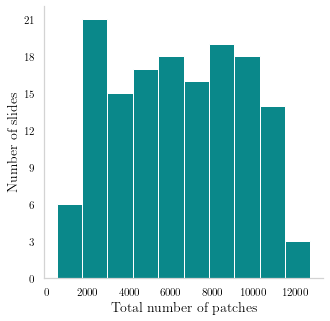

In [196]:
plt.rcParams["figure.figsize"] = [5, 5]
ax = plt.figure().gca()
ax.hist(df['Total_num_of_patches'], color=cd['green'])
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlabel('Total number of patches')
ax.set_ylabel('Number of slides')

save_fig(ax, 'patches_extracted_per_slide')

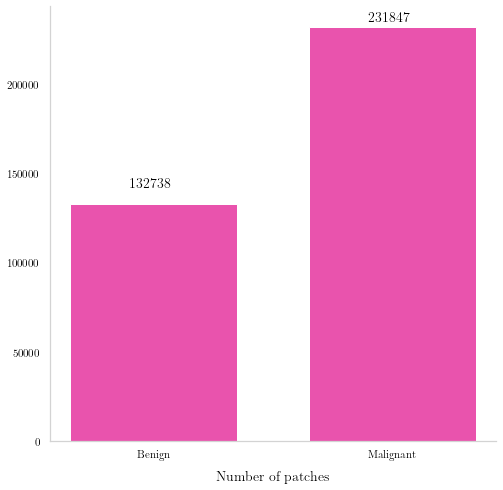

In [204]:
plt.rcParams["figure.figsize"] = [8, 8]
ax = plt.figure().gca()
ax.bar(["Benign", "Malignant"], [df['Final total benign'].sum(), df['Final total malignant'].sum()], color=cd['pink'], width=0.7)
for i, v in enumerate([df['Final total benign'].sum(), df['Final total malignant'].sum()]):
    ax.text(i-0.1, 142000 + i*93000, str(v), fontweight = 'bold')
width = 1.5
left_space = (1-width)/2
# ax.set_xlim(-0.5 + left_space, 2 - 0.5 + width/2 - left_space)
ax.set_xlabel('Number of patches', labelpad=10, position=(0, 10000))
# ax.set_title("Total number of patches per class", pad=20, ha='center')
# ax.spines['bottom'].set_bounds(-0.5 + left_space, 2 - 0.5 - left_space)
# ax.autoscale()
# plt.savefig('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/reports/data figs/patch_split.png')
save_fig(ax, 'class_dist_st1')

In [134]:
num_0, num_1 = [df['Final total benign'].sum(), df['Final total malignant'].sum()]
total=num_0+num_1
print(f"Benign %: {num_0/total*100}")
print(f"Malignant %: {num_1/total*100}")

Benign %: 36.407970706419626
Malignant %: 63.592029293580374


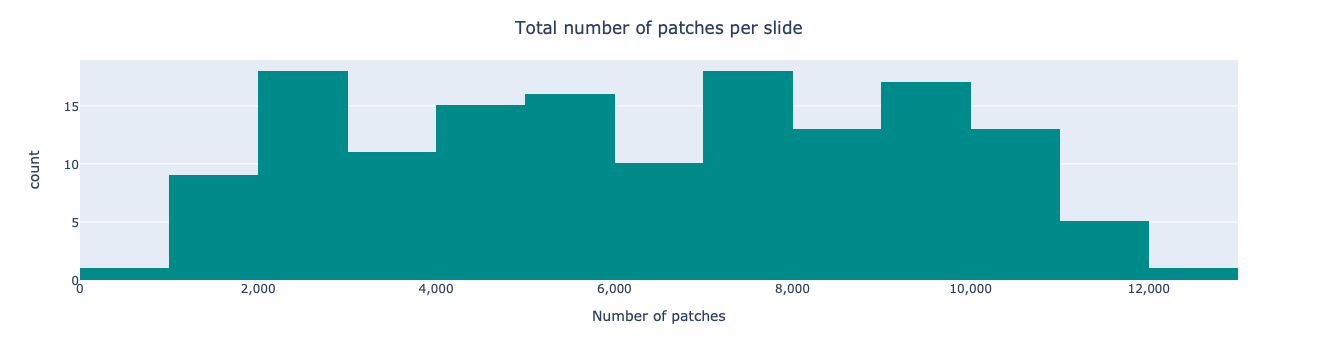

In [37]:
fig = px.histogram(df['Total_num_of_patches'],
                   labels={
                     "value": "Number of patches",
                     "count": "Number of slides"
                    }, 
                   color_discrete_sequence=['darkcyan'])
fig.update_layout(title={
        'text': "Total number of patches per slide",
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        showlegend=False,
        xaxis_tickformat=",.0f")
fig.show()

In [25]:
print(np.mean(df['Total_num_of_patches']))

6347.39455782313


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


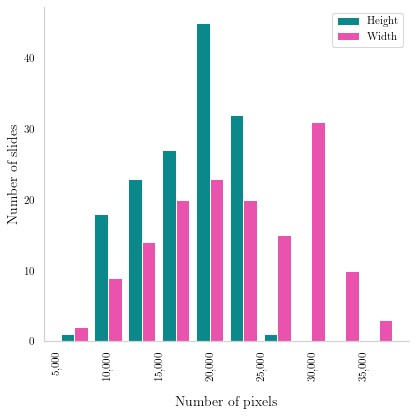

In [197]:
x = df['Level1_height']
y = df['Level1_width']
total_pixels_l0 = x * y

plt.rcParams["figure.figsize"] = [6, 6]
ax = plt.figure().gca()
ax.hist([x, y], color=[cd['green'], cd['pink']])
# ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# formatter = ticker.ScalarFormatter(useOffset=False, useMathText=True)
# formatter.set_scientific(False)
# ax.xaxis.set_major_formatter(formatter)
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='x', labelrotation=90.0)
ax.legend(labels=['Height', 'Width'])
ax.set_xlabel('Number of pixels', labelpad=15)
ax.set_ylabel('Number of slides')
plt.tight_layout()
save_fig(ax, 'slide_dimensions')

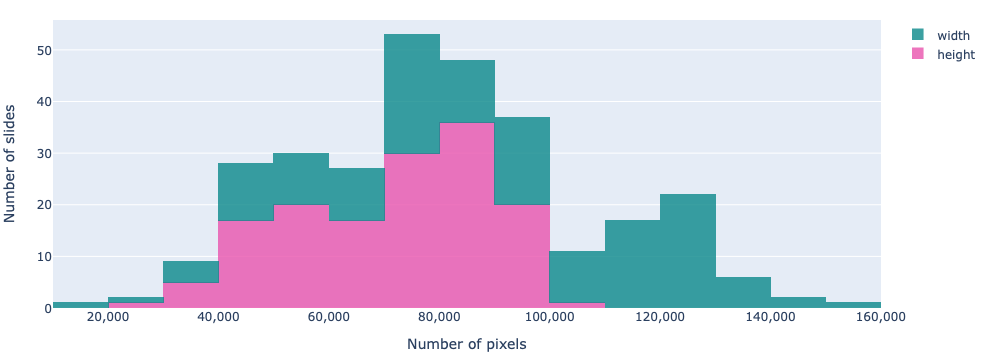

In [274]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df['Level0_height'], marker_color=cd['pink'], name="height"))
fig.add_trace(go.Histogram(x=df['Level0_width'], marker_color=cd['green'], name="width"))

# The two histograms are drawn on top of another
fig.update_layout(title={
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        xaxis_title_text='Number of pixels',
        xaxis_tickformat=",.0f",
        yaxis_title_text='Number of slides',
        barmode='stack', 
        width=700,
        margin=dict(l=50, r=50, b=50, t=20))
fig.update_traces(opacity=0.8)
fig.show()

Text(0, 0.5, 'Number of slides')

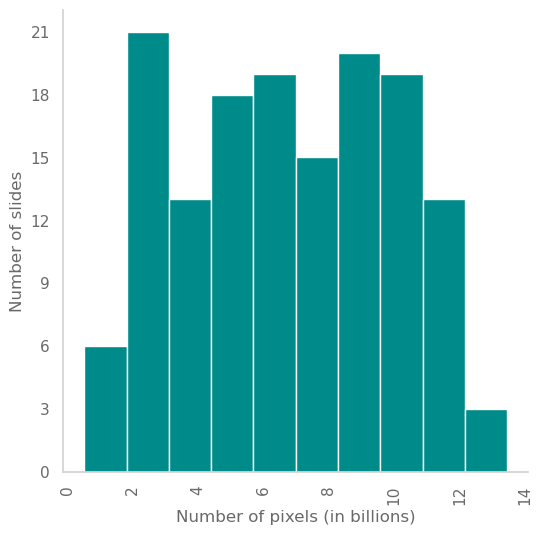

In [151]:
ax = plt.figure().gca()
pixels = x*y
ax.hist(pixels, color=['darkcyan'])
# formatter = ticker.ScalarFormatter(useOffset=False, useMathText=True)
# lambda x: '{:.0f}'.format(x*status.sum()/100)
formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1000000000:.0f}')
# formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.tick_params(axis='x', labelrotation=90.0)
ax.set_xlabel('Number of pixels (in billions)')
ax.set_ylabel('Number of slides')

In [ ]:
x = df['Final total benign']
y = df['Final total malignant']
background = df['Num_of_patches_discarded']
instances = np.arange(len(x))
plt.rcParams["figure.figsize"] = [12, 5]
bar_width=0.8
ax = plt.figure().gca()
ax.bar(instances, x, width=bar_width, label='Benign', color=cd['green'])
ax.bar(instances, y, width=bar_width, label='Malignant', color=cd['pink'], bottom=x)
ax.bar(instances, background, width=bar_width, label='Background', color=cd['yellow'], bottom=np.add(x, y))
# ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# formatter = ticker.ScalarFormatter(useOffset=False, useMathText=True)
# formatter.set_scientific(False)
# ax.xaxis.set_major_formatter(formatter)
# formatter = ticker.StrMethodFormatter('{x:,.0f}')
# ax.xaxis.set_major_formatter(formatter)
# ax.tick_params(axis='x', labelrotation=90.0)
# ax.legend()
ax.set_xlabel('Cases')
ax.set_ylabel('Number of tiles')
# plt.title('Distribution of tile classifications per case')
# plt.savefig('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/reports/data figs/patch_classifications_bar.png')
# save_fig(ax, 'class_distributions')
plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + 'class_distributions' + ".svg", format="svg", bbox_inches='tight')

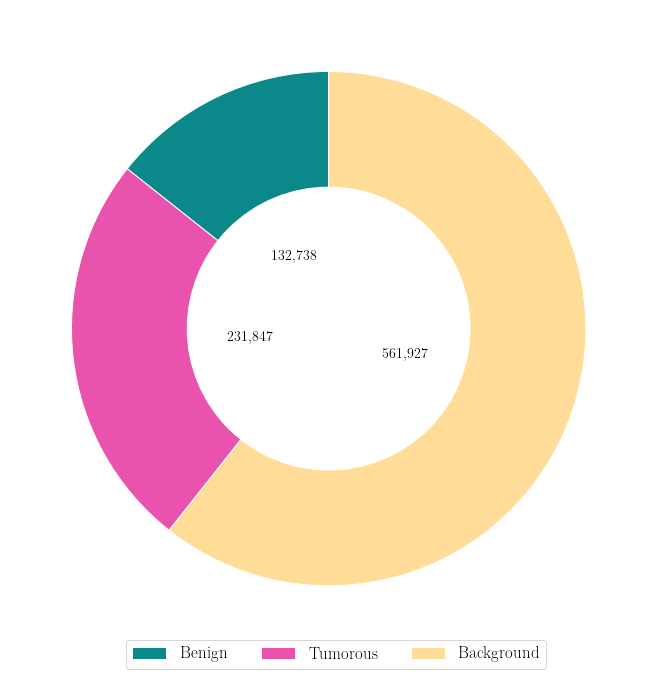

In [20]:
plt.rcParams["figure.figsize"] = [10, 10]
total_benign = df['Final total benign'].sum()
total_tumourous = df['Final total malignant'].sum()
total_background = df['Num_of_patches_discarded'].sum()
total_patches = total_benign + total_tumourous + total_background
plt.pie([total_benign, total_tumourous, total_background], colors=[cd['green'], cd['pink'], cd['yellow']], startangle=90, autopct=lambda x: '{:,.0f}'.format(x*total_patches/100), labeldistance=1.2, pctdistance=0.31)
# plt.pie(status, colors=['mediumpurple', 'mediumaquamarine'], startangle=90, autopct=lambda x: '{:.2f}%'.format(x))
plt.legend(labels=['Benign', 'Tumorous', 'Background'], fontsize=17, bbox_to_anchor=(0.51,0.08), loc="center", bbox_transform=plt.gcf().transFigure, ncol=3)

#draw circle
centre_circle = plt.Circle((0,0),0.550,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
# plt.axis('equal')  
plt.tight_layout()
# plt.title("Patch classifications", x=0.5, y=0.97)
# plt.show()
# plt.savefig('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/reports/data figs/patch_classifications_pie.png')
# save_fig(fig, 'pie_patch_classifications')
plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + 'pie_patch_classifications' + ".svg", format="svg", bbox_inches='tight')

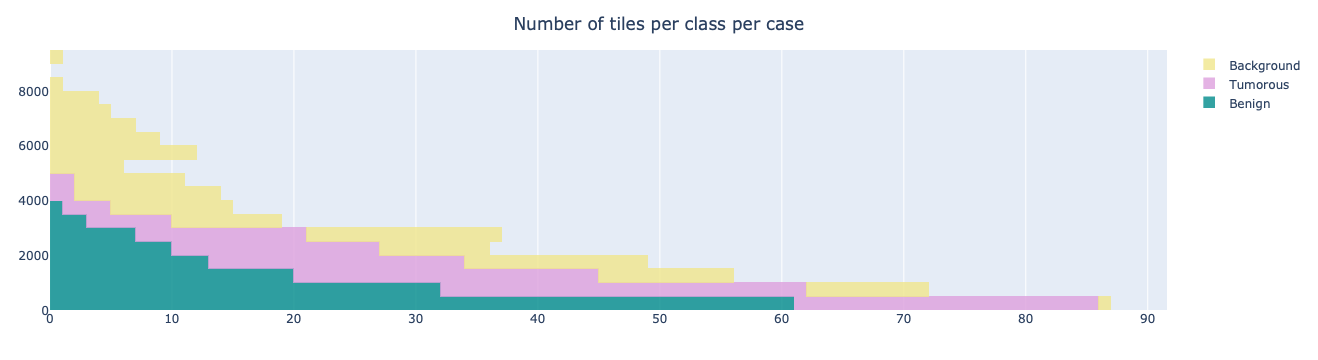

In [77]:
fig = go.Figure()
fig.add_trace(go.Histogram(y=df['Num_of_benign_tiles'], marker_color="darkcyan", name="Benign"))
fig.add_trace(go.Histogram(y=df['Num_of_tumourous_tiles'], marker_color="plum", name="Tumorous"))
fig.add_trace(go.Histogram(y=df['Num_of_patches_discarded'], marker_color="khaki", name="Background"))

# The two histograms are drawn on top of another
fig.update_layout(title={
        'text': "Number of tiles per class per case",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        # xaxis_title_text='Cases',
        xaxis_tickformat=",.0f",
        barmode='stack', 
        width=700,
        margin=dict(l=50, r=50, b=50, t=50))
fig.update_traces(opacity=0.8)
fig.show()

Text(0.5, 0, '% of background patches per image')

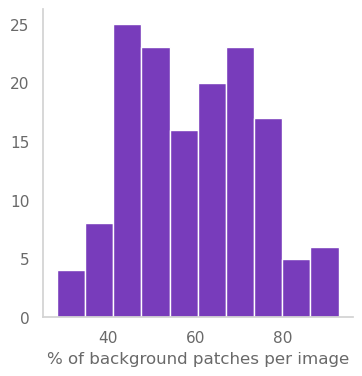

In [174]:
# Caluclaute percentage of background pixels per image
background_patches = df['Num_of_patches_discarded']
total_patches = df['Total_num_of_patches']

percentage_background = (background_patches/total_patches) * 100

ax = plt.figure().gca()

ax.hist(percentage_background, color=cd['purple'])
# formatter = ticker.ScalarFormatter(useOffset=False, useMathText=True)
# lambda x: '{:.0f}'.format(x*status.sum()/100)
# formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1000000000:.0f}')
# formatter.set_scientific(False)
# ax.xaxis.set_major_formatter(formatter)
# ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# ax.tick_params(axis='x', labelrotation=90.0)
ax.set_xlabel('% of background patches per image')
# ax.set_ylabel('Number of slides')

Next, calculate some statistics about the dimensions of the GIVEN images (i.e. at level 0)

In [ ]:
# Calculate average width, height

# Calculate average number of pixels

# Show distribution of image sizes/number of pixels

Also, calculate some information about images I am working with (i.e. level 1)

In [ ]:
# * idea: calculate the average size of the images used (in GBs)

## HER2 data

In [10]:
her2_df = pd.read_excel('/home/21576262@su/masters/data/HER2DataInfo.xlsx')
her2_df.drop(['Source', 'My ID'], axis=1, inplace=True)
her2_df = her2_df.rename(columns={'Case ID': 'File_name'})
# patches_df.drop(['Unnamed: 0'], axis=1, inplace=True)
display(her2_df.head())

,File_name,Clinical.HER2.status,HER2A.status,Unnamed: 5,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,TCGA-A1-A0SP-01Z-00-DX1,Negative,non-HER2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-A2-A04W-01Z-00-DX1,Positive,HER2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-A2-A04X-01Z-00-DX1,Positive,HER2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-A2-A0CX-01Z-00-DX1,Positive,HER2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-A2-A0EY-01Z-00-DX1,Positive,HER2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Delete NaN columns
for col in her2_df.columns:
   if her2_df[col].isnull().all():
     her2_df.drop([col], axis=1, inplace=True)

# Rename column to match previous dataframes
her2_df.rename(columns = {'Case ID':'File_name'}, inplace = True)

# display(her2_df.head())

In [12]:
# Keep only file names used for my project
file_names = df['File_name']
her2_filtered = her2_df[her2_df['File_name'].isin(file_names)]

In [13]:
# Combine dataframes on case ID
merged_df = pd.merge(df, her2_filtered, on='File_name', how='left')
display(merged_df)

,case_id,Final total benign,Final total malignant,File_name,Level0_factor,Level1_factor,Level2_factor,Level3_factor,Level0_height,Level0_width,...,Num_of_benign_tiles,Num_of_tumourous_tiles,Total num of remaining patches,% benign,% tumourous,Final total patches,Final % benign,Final % malignant,Clinical.HER2.status,HER2A.status
0,A8-A095,83,246,TCGA-A8-A095-01Z-00-DX1,1.0,4.000000,16.000000,NaN,41728.0,59648.0,...,83,246,329,25.227964,74.772036,329,25.227964,74.772036,Negative,non-HER2A
1,BH-A1EY,287,2793,TCGA-BH-A1EY-01Z-00-DX1,1.0,4.000069,16.001007,32.002015,69184.0,87371.0,...,372,2793,3165,11.753555,88.246445,3080,9.318182,90.681818,Negative,non-HER2A
2,C8-A12T,1077,1851,TCGA-C8-A12T-01Z-00-DX1,1.0,4.000082,16.001638,32.003275,73766.0,72969.0,...,1171,1860,3031,38.634114,61.365886,2928,36.782787,63.217213,Positive,HER2A
3,C8-A1HO,567,1571,TCGA-C8-A1HO-01Z-00-DX1,1.0,4.000029,16.001493,32.007061,69677.0,62832.0,...,567,1571,2138,26.520112,73.479888,2138,26.520112,73.479888,Negative,non-HER2A
4,AR-A1AN,321,398,TCGA-AR-A1AN-01Z-00-DX1,1.0,4.000124,16.003005,32.011297,48479.0,120904.0,...,321,398,719,44.645341,55.354659,719,44.645341,55.354659,Negative,non-HER2A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,AR-A1AY,1082,1235,TCGA-AR-A1AY-01Z-00-DX1,1.0,4.000034,16.001239,32.005222,58121.0,93296.0,...,1082,1235,2317,46.698317,53.301683,2317,46.698317,53.301683,Negative,non-HER2A
143,E2-A158,538,315,TCGA-E2-A158-01Z-00-DX1,1.0,4.000000,16.001405,32.008431,71160.0,126616.0,...,558,315,873,63.917526,36.082474,853,63.071512,36.928488,Negative,non-HER2A
144,AR-A0U3,1267,4262,TCGA-AR-A0U3-01Z-00-DX1,1.0,4.000000,16.001422,64.020873,67500.0,137088.0,...,1267,4272,5539,22.874165,77.125835,5529,22.915536,77.084464,Negative,non-HER2A
145,E2-A14V,963,1140,TCGA-E2-A14V-01Z-00-DX1,1.0,4.000077,16.001858,32.006608,77547.0,88536.0,...,963,1140,2103,45.791726,54.208274,2103,45.791726,54.208274,Positive,HER2A


## Pie chart

Create a pie chart for number of patches that are HER2+-

Positive    77
Negative    70
Name: Clinical.HER2.status, dtype: int64


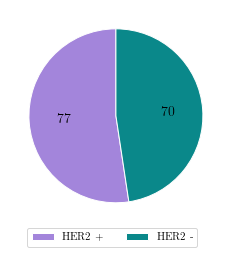

In [15]:
# Create pie chart
# can increase figsize for better resolution (for final saved image)
plt.rcParams["figure.figsize"] = [4, 4]
col_name = 'Clinical.HER2.status'
status_counts = merged_df[col_name].value_counts()
print(status_counts)
plt.pie(status_counts, colors=[cd['lightpurple'], cd['green']], startangle=90, autopct=lambda x: '{:.0f}'.format(x*status_counts.sum()/100))
# plt.pie(status, colors=['mediumpurple', 'mediumaquamarine'], startangle=90, autopct=lambda x: '{:.2f}%'.format(x))
plt.legend(labels=['HER2 +', 'HER2 -'], bbox_to_anchor=(0.5,0.08), loc="center", bbox_transform=plt.gcf().transFigure, ncol=2)
# plt.title("HER2 status: cases")
# plt.show()
plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + 'pie_her2_cases' + ".svg", format="svg", bbox_inches='tight')

In [164]:
count = merged_df[merged_df['Clinical.HER2.status'] == 'Negative']['Final total malignant'].sum()
print(count)

110461


Clinical.HER2.status
Negative    110461
Positive    121386
Name: Final total malignant, dtype: object
364585


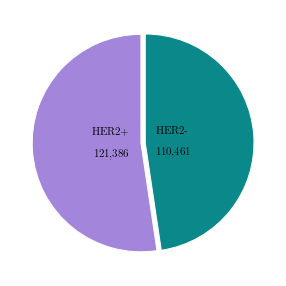

In [18]:
plt.rcParams["figure.figsize"] = [5, 5]
category_totals = merged_df.groupby('Clinical.HER2.status')['Final total malignant'].sum()
print(category_totals)
print(np.sum(category_totals.values) + merged_df['Final total benign'].sum())

# total_patches = total_benign + total_tumourous
plt.pie([category_totals[1], category_totals[0]], labels=[f'HER2+\n\n{category_totals[1]:,}', f'HER2-\n\n  {category_totals[0]:,}'], colors=[cd['lightpurple'], cd['green']], explode=[0.02, 0.02], startangle=90, labeldistance=0.1, pctdistance=0.65)
# plt.pie(status, colors=['mediumpurple', 'mediumaquamarine'], startangle=90, autopct=lambda x: '{:.2f}%'.format(x))
# plt.legend(labels=['Benign', 'Tumourous'], bbox_to_anchor=(0.5,0.08), loc="center", bbox_transform=plt.gcf().transFigure, ncol=2)
# plt.title("Patch classifications")
# plt.show()
plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + 'pie_her2_patches' + ".svg", format="svg", bbox_inches='tight')

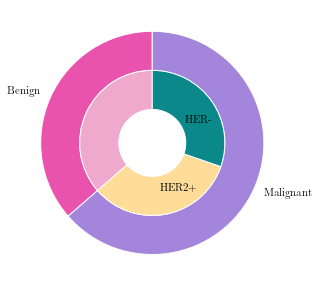

In [203]:
# Nested pie chart
total_benign = df['Final total benign'].sum()
total_tumourous = df['Final total malignant'].sum()
totalpos, totalneg = category_totals[1], category_totals[0]
# Create a pie chart for the main categories
fig, ax = plt.subplots()
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
width = 0.35

# Plot the main pie chart
ax.pie([total_benign, total_tumourous], labels=['Benign', 'Malignant'], colors=[cd['pink'], cd['lightpurple']], startangle=90, radius=1, wedgeprops=dict(width=width, edgecolor='w'))

# Plot the sub-categories pie chart
ax.pie([total_benign, totalpos, totalneg], labels=['', '\nHER2+', 'HER-'], colors=[cd['lightpink'], cd['yellow'], cd['green']], startangle=90, labeldistance=0.55, radius=1-width, wedgeprops=dict(width=width, edgecolor='w'))
# plt.show()
plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + 'nested_pie' + ".eps", format="eps", bbox_inches='tight')

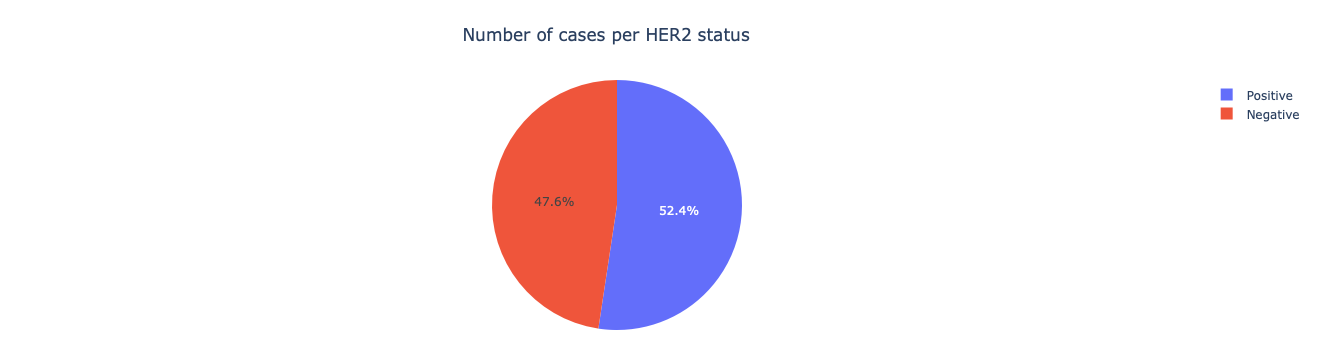

In [175]:
fig = px.pie(names=status_counts.index, values=status_counts.values, 
             color_discrete_map={'Positive':'darkcyan', 'Negative':'plum'})
fig.update_layout(title={
        'text': "Number of cases per HER2 status",
        'y':0.92,
        'x':0.46,
        'xanchor': 'center',
        'yanchor': 'top'},
        width=600,
        margin=dict(l=50, r=50, b=30, t=80))
fig.show()

Pie chart comparing number of benign and tumorous tiles available

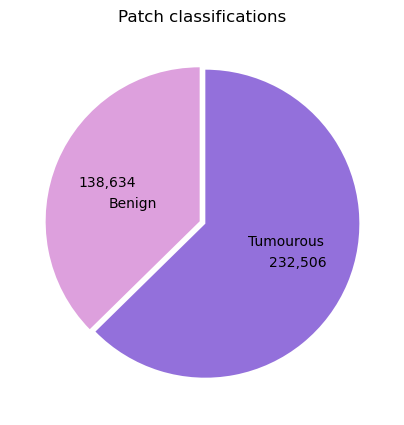

In [42]:
plt.rcParams["figure.figsize"] = [5, 5]
total_benign = df['Num_of_benign_tiles'].sum()
total_tumourous = df['Num_of_tumourous_tiles'].sum()
total_patches = total_benign + total_tumourous
plt.pie([total_benign, total_tumourous], labels=['Benign', 'Tumourous'], colors=['plum', 'mediumpurple'], explode=[0.02, 0.02], startangle=90, autopct=lambda x: '{:,.0f}'.format(x*total_patches/100), labeldistance=0.3, pctdistance=0.65)
# plt.pie(status, colors=['mediumpurple', 'mediumaquamarine'], startangle=90, autopct=lambda x: '{:.2f}%'.format(x))
# plt.legend(labels=['Benign', 'Tumourous'], bbox_to_anchor=(0.5,0.08), loc="center", bbox_transform=plt.gcf().transFigure, ncol=2)
plt.title("Patch classifications")
plt.show()

Clinical.HER2.status
Negative    110799
Positive    121707
Name: Num_of_tumourous_tiles, dtype: object
371140


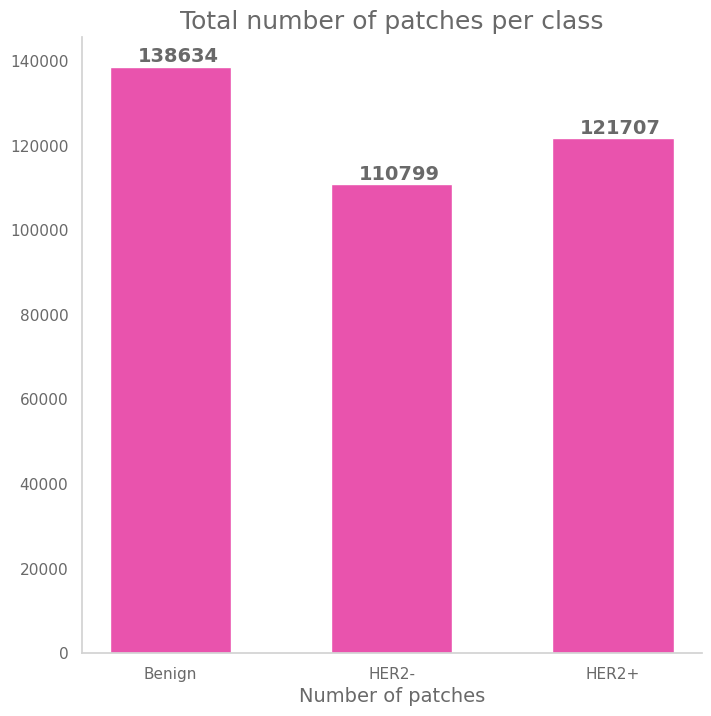

In [22]:
category_totals = merged_df.groupby('Clinical.HER2.status')['Num_of_tumourous_tiles'].sum()
print(category_totals)
print(np.sum(category_totals.values) + merged_df['Num_of_benign_tiles'].sum())

plt.rcParams["figure.figsize"] = [8, 8]
ax = plt.figure().gca()
ax.bar(["Benign", "HER2-", "HER2+"], [merged_df['Num_of_benign_tiles'].sum(), category_totals.values[0], category_totals.values[1]], color=cd['pink'], width=0.55)

for i, v in enumerate([merged_df['Num_of_benign_tiles'].sum(), category_totals.values[0], category_totals.values[1]]):
    ax.text(i-0.15, v+1000, str(v), fontweight = 'bold')
    
ax.set_xlabel('Number of patches')
ax.set_title("Total number of patches per class")
plt.savefig('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/reports/data figs/patch_splitx3.png')

## Matplotlib mosaic

<BarContainer object of 3 artists>

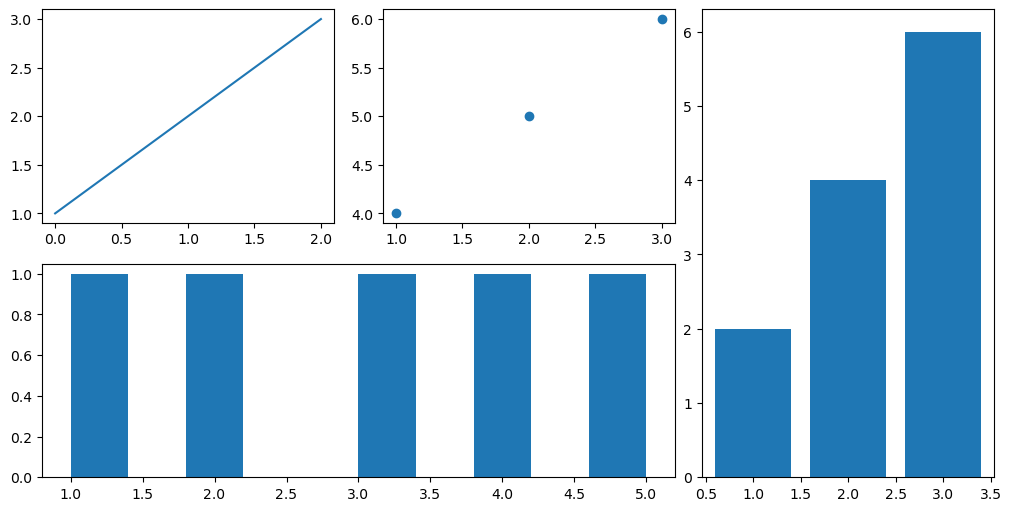

In [48]:
plt.rcParams["figure.figsize"] = [10, 5]
fig = plt.figure(layout='constrained')
mosaic = """
        abd
        ccd
        """
ax_dict = fig.subplot_mosaic(mosaic)

ax_dict['a'].plot([1, 2, 3])
ax_dict['b'].scatter([1, 2, 3], [4, 5, 6])
ax_dict['c'].hist([1, 2, 3, 4, 5])
ax_dict['d'].bar([1, 2, 3], [2, 4, 6])

### Save .png of WSIs

In [2]:
import os
from openslide import open_slide

img_dir = '/Volumes/AlexS/MastersData/SVS files/'
svs_files = os.listdir(img_dir)
save_dest = '/Users/alexandrasmith/Library/CloudStorage/OneDrive-StellenboschUniversity/Stellies/Masters/Visuals/WSI pngs/'

plt.rcParams['figure.dpi']=300

for img in svs_files:
    if os.path.isfile(save_dest + img.replace('.svs', '') + '.png'):
        continue
    else:
        # corrupt file
        if img.startswith('TCGA-BH-A0B4'):
            continue
        else:
            print(img)
            slide = open_slide(img_dir + img)
            slide_thumb = slide.get_thumbnail(size=(5000, 5000))
            plt.imshow(np.array(slide_thumb))
            plt.axis('off')
            plt.savefig(save_dest + img.replace('.svs', '') + '.png', bbox_inches='tight')

In [ ]:
######################

In [21]:
def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dl):

        idxs = batch[0].tolist()
        classes = batch[1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])
        else:
            raise ValueError("More than two classes detected")

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.set_xticks(ind, ind + 1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        num_images_seen = len(idxs_seen)

        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        )
        print("=============")
        print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

In [1]:
import sys
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
sys.path.append('/home/21576262@su/masters/')
from src.data.get_data import kfolds_split, get_train_dataloader, get_test_dataloader

In [25]:
# Number of classes in the dataset
num_classes = 2
# Batch size for training
batch_size = 32
# Number of epochs to train for
num_epochs = 50

model_name = 'inception'

Inception = True if model_name == 'inception' else False
InceptionResnet = True if model_name == 'inceptionresnet' else False

print(f"Model name: {model_name}")

SEED=42

# CROSS VALIDATION
k = 5
data_splits = kfolds_split(k, SEED)
fold_items = list(data_splits.items())

for i in range(1):

    # Get data
    fold, data = fold_items[i]
    train_cases = data['train'][0:10]
    test_cases = data['test']
    class_counts, train_dataloader = get_train_dataloader(train_cases, batch_size, Inception=False, InceptionResnet=False)
    
    # test_dataloader = get_test_dataloader(test_cases, batch_size, Inception=False, InceptionResnet=False)
    # dataloaders = {'train': train_dataloader, 'test': test_dataloader}
    
    # class_0_batch_counts, class_1_batch_counts, ids_seen = visualise_dataloader(dataloaders['train'], {0: "Benign", 1: "Malignant"})
    

Model name: inception


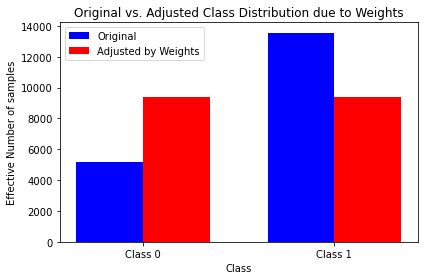

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have two classes 0 and 1
num_samples_class0, num_samples_class1 = class_counts

# Compute class weights
total_samples = num_samples_class0 + num_samples_class1
class_weights = [total_samples / (2 * count) for count in original_counts]

# Compute "adjusted" counts based on weights
adjusted_counts = [count * weight for count, weight in zip(original_counts, class_weights)]

# Plot
bar_width = 0.35
index = np.arange(2)

fig, ax = plt.subplots()
bar1 = ax.bar(index, original_counts, bar_width, label='Original', color='b')
bar2 = ax.bar(index + bar_width, adjusted_counts, bar_width, label='Adjusted by Weights', color='r')

ax.set_xlabel('Class')
ax.set_ylabel('Effective Number of samples')
ax.set_title('Original vs. Adjusted Class Distribution due to Weights')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.legend()

plt.tight_layout()
plt.show()

In [41]:
def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dl):

        idxs = batch[0][:, 0].tolist()
        classes = batch[1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        # idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])
        else:
            raise ValueError("More than two classes detected")
        
    # print(class_0_batch_counts)

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            color=cd['green'],
            label=(id_to_label[0] if id_to_label is not None else "0")
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            color=cd['pink'],
            label=(id_to_label[1] if id_to_label is not None else "1")
        )
        ax.set_xticks(ind, ind + 1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        # num_images_seen = len(idxs_seen)

        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 32).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 32).mean()}'
        )
        print("=============")
        # print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, 0

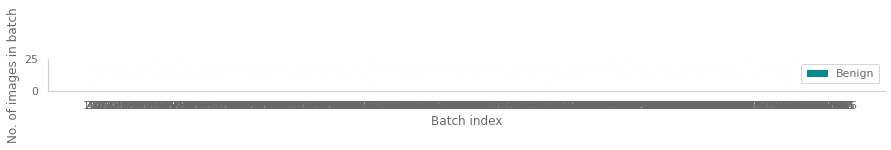

Avg Proportion of Benign per batch: 0.49856015358361777
Avg Proportion of Malignant per batch: 0.5001599829351536


In [42]:
class_0_batch_counts, class_1_batch_counts, ids_seen = visualise_dataloader(train_dataloader, {0: "Benign", 1: "Malignant"})

In [3]:
import matplotlib.pyplot as plt

def plot_class_distribution(counts, title):
    labels, values = zip(*counts.items())
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.show()

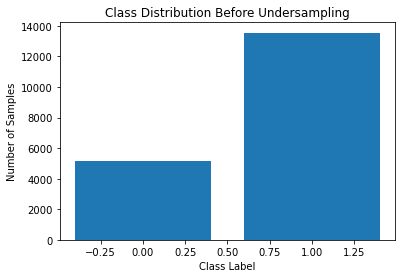

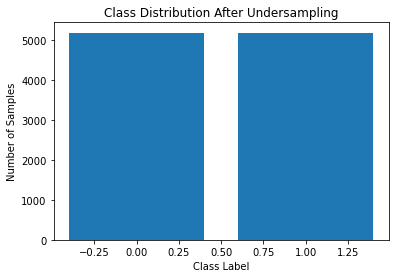

In [6]:
plot_class_distribution(class_counts_before, "Class Distribution Before Undersampling")
plot_class_distribution(class_counts_after, "Class Distribution After Undersampling")